In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir='/content/drive/MyDrive/ucd/'
base_dir='../../../folders/'

In [2]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model,load_model
from tensorflow.keras.models import Model
from keras.layers import Conv1D, SeparableConv1D,GlobalAveragePooling1D,Add,concatenate, Conv2D,MaxPooling1D,MaxPooling2D, Dropout,Dense,Flatten,Activation, Flatten, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import scipy.stats as stats
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

C:\Users\zazaz\AppData\Local\Temp\ipykernel_1760\3697400870.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from tensorflow.keras import backend as K


def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    def precision_m(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
with open(base_dir+f'all/train_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_train = res['x_train']
                y_train = res['y_train']
del res
x_train=np.reshape(x_train,(len(x_train),3840,1))
print(x_train.shape)
print(y_train.shape)

(49797, 3840, 1)
(49797, 4)


In [5]:
with open(base_dir+f'all/test_all.pkl', 'rb') as f:
                res = pickle.load(f)
                x_test = res['x_test']
                y_test = res['y_test']
del res
x_test=np.reshape(x_test,(len(x_test),3840,1))
print(x_test.shape)
print(y_test.shape)

(12450, 3840, 1)
(12450, 4)


In [6]:
input_shape = (3840,1)
num_classes = 4 


def inception_module(inputs, filters):
    tower_1 = Conv1D(filters=filters[0], kernel_size=1, padding='same', activation='relu')(inputs)
    
    tower_2 = Conv1D(filters=filters[1], kernel_size=1, padding='same', activation='relu')(inputs)
    tower_2 = Conv1D(filters=filters[2], kernel_size=3, padding='same', activation='relu')(tower_2)
    
    tower_3 = Conv1D(filters=filters[3], kernel_size=1, padding='same', activation='relu')(inputs)
    tower_3 = Conv1D(filters=filters[4], kernel_size=5, padding='same', activation='relu')(tower_3)
    
    tower_4 = MaxPooling1D(pool_size=3, strides=1, padding='same')(inputs)
    tower_4 = Conv1D(filters=filters[5], kernel_size=1, padding='same', activation='relu')(tower_4)
    
    output = concatenate([tower_1, tower_2, tower_3, tower_4], axis=2)
    return output

input_layer = Input(shape=(input_shape)) # Define your input shape

# Stem
x = BatchNormalization()(input_layer)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)

# Inception modules
x = inception_module(x, filters=[64, 96, 128, 16, 32, 32])
x = inception_module(x, filters=[128, 128, 192, 32, 96, 64])

# Add more inception modules as needed

# Fully connected layers
x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output_layer = Dense(num_classes,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax')(x)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3840, 1)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 3840, 1)     4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 3838, 32)     128         ['batch_normalization[0][0]']    
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3836, 64)     6208        ['conv1d[0][0]']             

In [7]:
checkpoint = ModelCheckpoint(base_dir+"models/inceptionV3.keras")
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy',f1])
history=model.fit(x_train,y_train,batch_size=256,epochs=100,callbacks=[checkpoint], validation_split=0.10)

Epoch 1/100
176/176 [==============================] - 60s 322ms/step - loss: 1.4123 - accuracy: 0.4961 - f1: 0.3320 - val_loss: 1.2341 - val_accuracy: 0.5245 - val_f1: 0.0804
Epoch 2/100
176/176 [==============================] - 56s 319ms/step - loss: 1.2002 - accuracy: 0.5257 - f1: 0.3969 - val_loss: 1.1975 - val_accuracy: 0.5353 - val_f1: 0.4209
Epoch 3/100
176/176 [==============================] - 56s 319ms/step - loss: 1.1801 - accuracy: 0.5359 - f1: 0.4209 - val_loss: 1.1388 - val_accuracy: 0.5633 - val_f1: 0.3882
Epoch 4/100
176/176 [==============================] - 56s 319ms/step - loss: 1.1551 - accuracy: 0.5518 - f1: 0.4637 - val_loss: 1.1349 - val_accuracy: 0.5731 - val_f1: 0.4408
Epoch 5/100
176/176 [==============================] - 56s 320ms/step - loss: 1.1215 - accuracy: 0.5722 - f1: 0.4970 - val_loss: 1.3195 - val_accuracy: 0.5030 - val_f1: 0.4656
Epoch 6/100
176/176 [==============================] - 58s 332ms/step - loss: 1.1119 - accuracy: 0.5805 - f1: 0.5143 - v

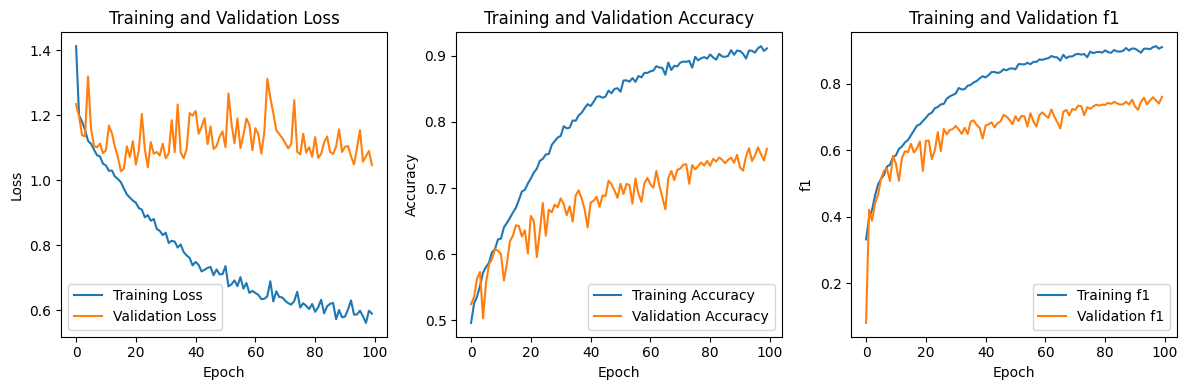

In [8]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot F1
plt.subplot(1, 3, 3)
plt.plot(history.history['f1'], label='Training f1')
plt.plot(history.history['val_f1'], label='Validation f1')
plt.title('Training and Validation f1')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
del x_train
del y_train

In [10]:
# model=load_model(base_dir+"models/inceptionV3.keras",custom_objects={'f1':f1})
# model.summary()

In [11]:
y_pred=model.predict(x_test,batch_size=256)
y_pred = to_categorical(np.argmax(y_pred, axis=1), 4).astype(int)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

49/49 [==============================] - 5s 97ms/step


In [12]:
print(classification_report(y_test,y_pred,target_names=['WAKE','REM','LIGHT','DEEP']))

              precision    recall  f1-score   support

        WAKE       0.80      0.72      0.76      2810
         REM       0.77      0.65      0.71      1809
       LIGHT       0.77      0.84      0.80      6233
        DEEP       0.68      0.69      0.68      1598

    accuracy                           0.77     12450
   macro avg       0.76      0.73      0.74     12450
weighted avg       0.77      0.77      0.76     12450



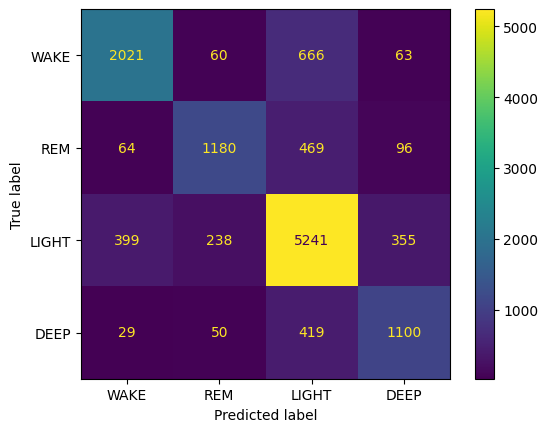

In [13]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['WAKE','REM','LIGHT','DEEP'])
disp.plot()
plt.show()